In [1]:
import numpy as np
import sys
sys.path.append('../../otf/otf_engine')
import gp, env, struc, kernels, otf
sys.path.append('../../otf/modules')
import qe_parsers, analyze_gp, parse_output_temp, otf_parser, calculate_rdf, \
    analyze_otf, crystals, activation_parser, analyze_md, otf_parser_v2, analyze_gp_v2
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import copy

# return to default and make the fontbigger
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 12}
plt.rc('font', **font)

# Quench Figure

In [2]:
file_name = '/Users/jonpvandermause/Research/GP/otf/datasets/Quench_Runs/Al_Quench_5ps_2-23/otf_run.out'
otf_run = otf_parser_v2.OtfAnalysis(file_name)

In [3]:
# record msd and dft calls
end = 130

quench_times = otf_run.times[0 : end]
quench_msds = otf_run.msds[0 : end]

In [4]:
# get otf times and msds
dft_times_plot = otf_run.dft_times[1:-1]
dft_msds_plot = []
for time in dft_times_plot:
    ind = otf_run.times.index(time)
    dft_msds_plot.append(otf_run.msds[ind])

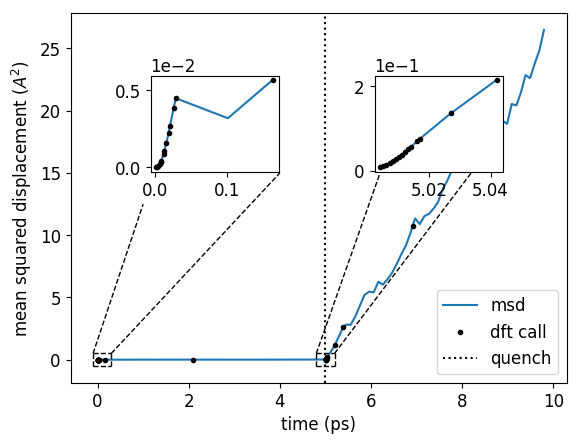

In [12]:
# make figure
f, ax1 = plt.subplots(1, 1)

# plot vertical line for every dft call
ax1.plot(quench_times, quench_msds, label='msd')

ax1.plot(dft_times_plot, dft_msds_plot, 'k.', label='dft call')
ax1.axvline(5, color='k', linestyle=':', label='quench')

# solid subplot
ax2 = plt.axes([.25, .55, .2, .2])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.plot(quench_times[0 : 15], quench_msds[0:15])
ax2.plot(dft_times_plot[0:14], dft_msds_plot[0:14], 'k.', label='dft call')

# solid dotted box
left = -0.1
right = 0.3
down = -0.5
up = 0.5
ax1.plot([left, right], [up, up], 'k--', linewidth=1)
ax1.plot([left, right], [down, down], 'k--', linewidth=1)
ax1.plot([left, left], [down, up], 'k--', linewidth=1)
ax1.plot([right, right], [down, up], 'k--', linewidth=1)

ax1.plot([left, 1], [up, 12.5], 'k--', linewidth=1)
ax1.plot([right, 4], [up, 15], 'k--', linewidth=1)

# liquid subplot
ax3 = plt.axes([.6, .55, .2, .2])
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.plot(quench_times[64 : 79], quench_msds[64 : 79])
ax3.plot(dft_times_plot[15:30], dft_msds_plot[15:30], 'k.', label='dft call')

# liquid dotted box
left = 4.8
right = 5.2
down = -0.5
up = 0.5
ax1.plot([left, right], [up, up], 'k--', linewidth=1)
ax1.plot([left, right], [down, down], 'k--', linewidth=1)
ax1.plot([left, left], [down, up], 'k--', linewidth=1)
ax1.plot([right, right], [down, up], 'k--', linewidth=1)

ax1.plot([left, 6.2], [up, 15], 'k--', linewidth=1)
ax1.plot([right, 8.2], [up, 15], 'k--', linewidth=1)


ax1.set_xlabel('time (ps)')
ax1.set_ylabel('mean squared displacement ($A^2$)')


ax1.legend(loc='lower right')


f.savefig('melt_msd_3.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [80]:
# calculate solid rdf
position_list = otf_run.position_list
cell = 8.092 * np.eye(3)
species = ['Al']*32
snaps = np.arange(0, 60, 1)
cutoff = 8.092
bins = 200

sol_rs, sol_rad_dist, sol_atom_count = \
    calculate_rdf.calculate_rdf(position_list, cell, species, snaps, cutoff, bins)

# calculate liquid rdf
position_list = otf_run.position_list
cell = 8.092 * np.eye(3)
species = ['Al']*32
snaps = np.arange(100, 880, 1)
cutoff = 8.092
bins = 200

liq_rs, liq_rad_dist, liq_atom_count = \
    calculate_rdf.calculate_rdf(position_list, cell, species, snaps, cutoff, bins)

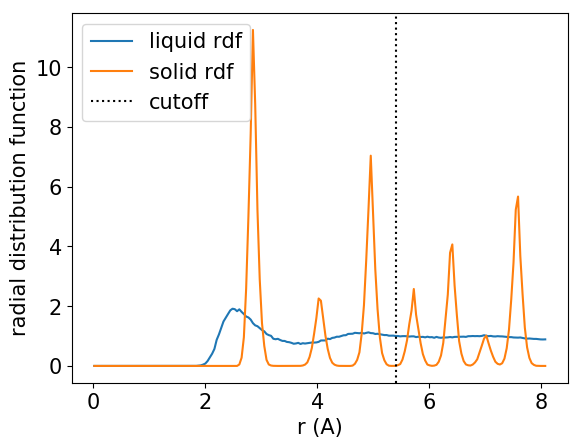

In [83]:
# plot rdf
f, (ax1) = plt.subplots(1, 1)
ax1.plot(liq_rs, liq_rad_dist, label='liquid rdf')
ax1.plot(sol_rs, sol_rad_dist, label='solid rdf')
ax1.set_xlabel('r (A)')
ax1.set_ylabel('radial distribution function')
ax1.axvline(5.4, color='k', linestyle=':', label='cutoff')
ax1.legend()

f.savefig('rdf.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [30]:
# record uncertainties
mean_stds = []
max_stds = []

for std in otf_run.uncertainty_list:
    mean_stds.append(np.mean(std))
    max_stds.append(np.max(std))
    
mean_stds = np.array(mean_stds)
max_stds = np.array(max_stds)

plot_max_stds = max_stds[0 : end]
plot_mean_stds = mean_stds[0 :end]

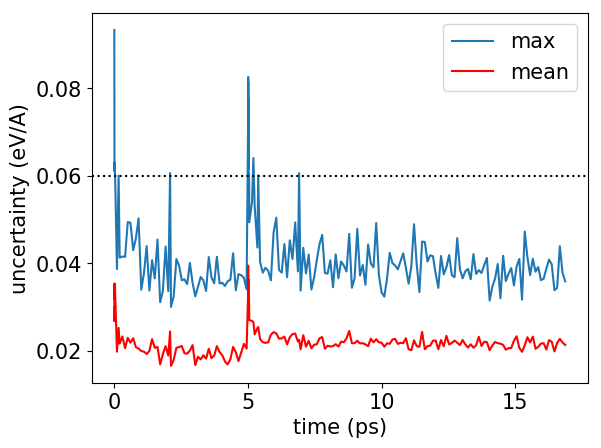

In [31]:
# plot uncertainties
f = plt.figure()
plt.plot(quench_times, plot_max_stds, label='max')
plt.plot(quench_times, plot_mean_stds, color='r', label='mean')
plt.axhline(0.06, color='k', linestyle=':')
plt.xlabel('time (ps)')
plt.ylabel('uncertainty (eV/A)')
plt.legend()

f.savefig('uncertainty.pdf', format='pdf',bbox_inches='tight')
plt.show()

# Cutoff cartoon

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# return to default and make the fontbigger
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 15}
plt.rc('font', **font)

In [5]:
# plot circle
def plot_circle(lp, rp, nop, style, label, markersize):
    radius = (rp - lp) / 2
    circ1_xs = np.linspace(lp, rp, nop)
    circ1_ys = np.sqrt(radius**2 - circ1_xs**2)

    plt.plot(circ1_xs, circ1_ys,style,label=label, linewidth = markersize)
    plt.plot(circ1_xs, -circ1_ys,style, linewidth = markersize)

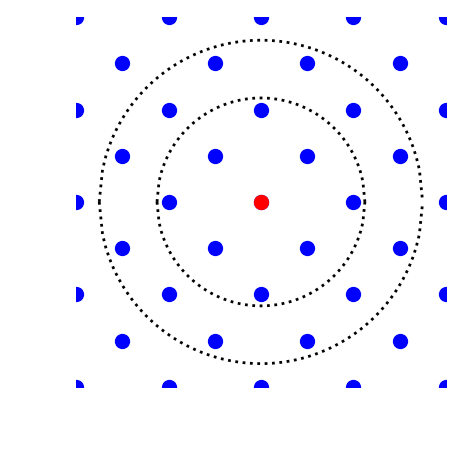

In [6]:
# draw atoms
alat = 4
fac = 2
f = plt.figure()
xs = np.linspace(-fac * alat, fac * alat, 2*fac+1)
ys = np.linspace(-fac * alat, fac * alat, 2*fac+1)

for x in xs:
    for y in ys:
        plt.plot(x, y, 'b.', MarkerSize=20)
        plt.plot(x+alat/2, y+alat/2, 'b.', MarkerSize=20)
        
# draw special atom
plt.plot(0, 0, 'r.', MarkerSize=20)

# draw circle of radius 5
lp = -5
rp = 5
nop = 100

cutoff2 = 7
cutoff3 = 4.5

plot_circle(-cutoff2, cutoff2, nop,'k:','5 A', 2)
plot_circle(-cutoff3, cutoff3, nop,'k:','5 A', 2)
# plot_circle(-7.5, 7.5, nop,'k:','7 A')
# plot_circle(-10, 10, nop,'k:','10 A')

plt.xlabel('x (angstrom)')
plt.ylabel('y (angstrom)')
        
plt.axis('scaled')
window = 8
plt.xlim(-window, window)
plt.ylim(-window, window)
plt.axis('off')
plt.show()
f.savefig('concentric.pdf', format='pdf',bbox_inches='tight')

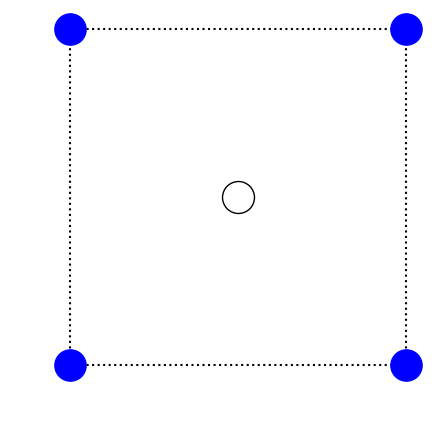

In [78]:
msize = 45
f = plt.figure()
plt.plot([0, 0], [0, 1], 'k:')
plt.plot([0, 1], [0, 0], 'k:')
plt.plot([1, 1], [0, 1], 'k:')
plt.plot([0, 1], [1, 1], 'k:')

plt.plot(0, 0, 'b.', MarkerSize=msize)
plt.plot(0, 1, 'b.', MarkerSize=msize)
plt.plot(1, 1, 'b.', MarkerSize=msize)
plt.plot(1, 0, 'b.', MarkerSize=msize)
plt.plot(0.5, 0.5, 'ko', MarkerSize=23, mfc='none')
# plt.plot(x+alat/2,y+alat/2, 'b.', MarkerSize=msize)

plt.axis('scaled')

plt.axis('off')
plt.show()
f.savefig('cell.pdf', format='pdf',bbox_inches='tight')

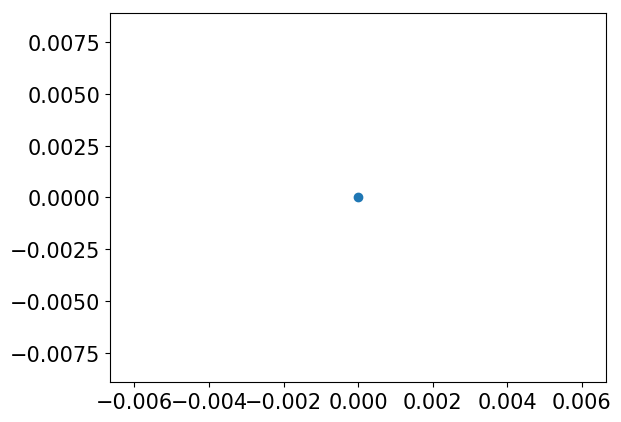

In [42]:
plt.scatter(0, 0)
plt.show()